In [84]:
################ IMPORTS ################
#!pip3 install torch
import torch as torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import threading as thr
import time
import random as rand
import pandas as pd
#########################################


In [85]:
torch.cuda.empty_cache()

In [86]:
################ Initialising ################
def pcInit():
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use if your machine is Windows or Linux
  print(device) # Debugging to check if the device is set up correctly!
  return device


def openSet(defaultPath = True) -> pd.DataFrame:
  """Opens the CSV file using pandas' in-built method"""
  if defaultPath: filepath = "london_weather.csv"
  else: filepath = input("enter file location: ")
  return pd.read_csv(filepath)

device = pcInit()
df = openSet(defaultPath = True)
df
# default path: /content/drive/MyDrive/ University/Undergraduate /Year 3/embedded/sem 2/london_weather.csv
##############################################

cuda:0


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [87]:
from posixpath import defpath
################ Data Pre-Processing #############

# Turn the date string objects into actual datetime objects
def dateTimeFmt(df):
  df.loc[:, "date"] = pd.to_datetime(df.loc[:, "date"], format='%Y%m%d')
  #df = df.drop(['date'], axis=1)
  return df

# Function for dealing with n/a observations. mode = ["rmv", "bfill", "ffill", "interpolate"]
# Mode is how the function should deal with the missing data. rmv = remove the instance/datapoint.
#mean = set the n/a observation to the mean value of the feature. For bfill, ffill, and interpolate see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
def naVals(df, mode = "rmv", printNAs = True):
  if printNAs:
    print("Number of N/A observations per feature:")
    print(df.isna().sum())

  # remove the instances
  if mode == "rmv": df.dropna(inplace = True)
  elif mode == "interpolate": 
    if df["snow_depth"].isna().all(): 
      df.fillna(0, inplace=True)
    df.interpolate(method = "linear", inplace = True)
  else: df.fillna(inplace = True, method = mode)

  if printNAs:
    print("After cleaning:")
    print(df.isna().sum())

  return df

# Scales/Normalises & splits the data#
# T = Number of timesteps
def dataScale(df, T = 20):
  size = df.shape[1]
  scaler = StandardScaler()
  scaler.fit(df[:size + T - 1])
  df = scaler.transform(df)
  return df

def dataSplit(df, trainPortion = 0.8, T = 20):
  N = len(df) - T
  trainingSize = int(len(df) * trainPortion)
  setSize = df.shape[1]
  npData = dataScale(df)
  targets = df["precipitation"].values

  # Train:
  Xtrain = np.zeros((trainingSize, T, setSize))
  Ytrain = np.zeros((trainingSize, 1))

  for t in range(trainingSize):
    Xtrain[t, :, :] = npData[t:t+T]
    Ytrain[t] = (targets[t+T])


  # Test
  print("trainingsize", N - trainingSize)
  print("T", T)
  print("setSize", setSize)
  print("==================================")
  Xtest = np.zeros((N - trainingSize, T, setSize))
  Ytest = np.zeros((N - trainingSize, 1))

  for i in range(N - trainingSize):
    t = i + trainingSize
    Xtest[i, :, :] = npData[t:t+T]
    Ytest[i] = (targets[t+T])


  XTrain = torch.from_numpy(Xtrain.astype(np.float32))
  YTrain = torch.from_numpy(Ytrain.astype(np.float32))
  XTest = torch.from_numpy(Xtest.astype(np.float32))
  YTest = torch.from_numpy(Ytest.astype(np.float32))
  return {
      "datasets": [XTrain, YTrain, XTest, YTest],
      "dimensions": {
          "timesteps": T,
          "dimension": setSize,
          "N": N
          }
      }
#####################################################

def preprocess(df: pd.DataFrame, trainPercent = 0.8, timestep = 20):
  df = dateTimeFmt(df)
  dfDated = df
  df = df.drop(['date'], axis=1)
  df = naVals(df, printNAs = False, mode = "interpolate")
  print(dfDated.shape[0], df.shape[0])
  vars = dataSplit(df, trainPortion = trainPercent, T = timestep)
  vars["dfDated"] = dfDated
  vars["df"] = df
  #df.to_csv("london_weather.csv", index = False)
  return vars

vars = preprocess(df)
XTrain, YTrain, XTest, YTest = vars["datasets"][0], vars["datasets"][1], vars["datasets"][2], vars["datasets"][3]
T, D, N = vars["dimensions"]["timesteps"], vars["dimensions"]["dimension"], vars["dimensions"]["N"]
dfDated = vars["dfDated"]

# for testing:
#XTrain = XTrain[:200]
#YTrain = YTrain[:200]
#XTest  = XTest[:50]
#YTest  = YTest[:50]   



15341 15341
trainingsize 3049
T 20
setSize 9


In [88]:
#################### Model ####################

class lstmAlgorithm(nn.Module):
  def __init__(self, inputD, hiddenD, layerD, outputD, epochs = 200, learningRate = 0.01):
    super(lstmAlgorithm, self).__init__()
    self.M = hiddenD
    self.L = layerD
    self.epochs = epochs
    self.trainLosses = np.zeros(epochs)
    self.testLosses = np.zeros(epochs)

    self.rnn = nn.LSTM(input_size = inputD, hidden_size = hiddenD, num_layers = layerD, batch_first = True)

    self.fc = nn.Linear(hiddenD, outputD)

    # Loss and optimiser
    self.criterion = nn.MSELoss()
    self.optimiser = torch.optim.SGD(self.parameters(), lr = learningRate, momentum = 0.9, weight_decay = 1e-4)
  
  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

  def trainEpoch(self, XTrain, YTrain, XTest, YTest, epoch = 1):
    self.optimiser.zero_grad() # zero the gradients at the start of the epoch

    # Forward pass
    outputs = self(XTrain)
    loss = self.criterion(outputs, YTrain)

    # Backpropagation
    loss.backward()

    grads = [p.grad.clone() for p in self.parameters()]

    # Train loss
    self.trainLosses[epoch] = loss.item()

    # Test loss
    testOutputs = self(XTest)
    testLoss = self.criterion(testOutputs, YTest)
    self.testLosses[epoch] = testLoss.item()

    if (epoch + 1) % 10 == 0:
      print(f'At epoch {epoch+1} of {self.epochs}, Train Loss: {loss.item():.3f}, Test Loss: {testLoss.item():.3f}')

    return self.trainLosses, self.testLosses, grads
  
  def updateWeights(self):
    self.optimiser.step()

In [89]:
# Hyper params
N = 3
epochs = 1000
grads = [None]*N
models = [lstmAlgorithm(D, 512, 2, 1, epochs=epochs).to(device) for _ in range(N)]
X_chunks = torch.chunk(XTrain.to(device),  N, dim=0)
Y_chunks = torch.chunk(YTrain.to(device),  N, dim=0)
XTest, YTest = XTest.to(device), YTest.to(device)


In [90]:
import sys

compBarrier = thr.Barrier(N+1)
updateBarrier = thr.Barrier(N+1)

def aggregate(grads_list):
  stacked = torch.stack(grads_list, dim=0)
  return torch.mean(stacked, dim=0)

mutex = thr.Lock()
def addGrad(i, grad):
  print("THREAD", i, "IS CURRENTLY WAITING FOR THE `grads` MUTEX TO BE ACQUIRED...")
  mutex.acquire()
  try: grads[i] = grad
  finally: 
    mutex.release()
    print("THREAD", i, "HAS RELEASED THE `grads` MUTEX...")

def worker(threadNum, XTrain, YTrain, XTest, YTest):
  # We wrap in a try-catch block in case one worker silently crashes. If there's no error,
  # we wont know it's dead, so there'll be a random deadlock at the barriers.
  try:
    LSTMi = models[threadNum]
    for epoch in range(LSTMi.epochs):
      print("================================")
      _, _, grad = LSTMi.trainEpoch(XTrain, YTrain, XTest, YTest, epoch = epoch)
      addGrad(threadNum, grad)
      print("THREAD:", threadNum, ", EPOCH:", epoch, "GRAD:", grad)
      compBarrier.wait()
      print("THREAD", threadNum, "is waiting for compBarrier. EPOCH:", epoch)
      updateBarrier.wait()
      print("THREAD", threadNum, "is waiting for updateBarrier. EPOCH:", epoch)
      print("================================")
  except Exception as e:
    print("Thread", threadNum, "died. Error:", e)
    sys.exit()
    
def controller():
  global models
  M = df.shape[0]
  threads = []
  for i in range(N):
    t = thr.Thread(target=worker, args=(i, X_chunks[i], Y_chunks[i], XTest, YTest), daemon=True)
    t.start()
    print("Started thread", i, " using chunk", i, ".")
    threads.append(t)
    
  for epoch in range(epochs):
    print("================================")
    compBarrier.wait()           # wait for all workers to finish computing

    aveGrads = []
    for parami in range(len(list(models[0].parameters()))):
      # Get that specific i-th parameter's gradient from each model
      paramGrads = [grads[m][parami] for m in range(N)]
      aveGrads.append(aggregate(paramGrads))

    print("[main] NEW GRADS:", aveGrads)

    for model in models:
      for (p, g) in zip(model.parameters(), aveGrads):
        p.grad = g.clone()

      model.updateWeights() # optimiser step
    updateBarrier.wait() # let workers continue to next epoch

  for t in threads:
      t.join()

controller()

Started thread 0  using chunk 0 .
Started thread 1  using chunk 1 .
Started thread 2  using chunk 2 .
THREAD 1 IS CURRENTLY WAITING FOR THE `grads` MUTEX TO BE ACQUIRED...
THREAD 1 HAS RELEASED THE `grads` MUTEX...
THREAD: 1 , EPOCH: 0 GRAD: THREAD 2 IS CURRENTLY WAITING FOR THE `grads` MUTEX TO BE ACQUIRED...
THREAD 2 HAS RELEASED THE `grads` MUTEX...
THREAD: 2 , EPOCH: 0 GRAD: THREAD 0 IS CURRENTLY WAITING FOR THE `grads` MUTEX TO BE ACQUIRED...
THREAD 0 HAS RELEASED THE `grads` MUTEX...
THREAD: 0 , EPOCH: 0 GRAD: [tensor([[-1.1304e-04,  4.2015e-04,  2.0186e-03,  ..., -2.6145e-04,
          7.4323e-05, -9.3583e-05],
        [-8.2226e-04,  3.8657e-03,  2.2880e-02,  ..., -4.8112e-04,
         -2.7999e-04, -1.7155e-03],
        [ 1.5120e-04, -5.0256e-04, -2.6063e-03,  ...,  1.9288e-04,
         -8.9719e-05,  1.4986e-04],
        ...,
        [ 1.4836e-04, -9.4018e-05,  5.8066e-04,  ...,  1.3914e-04,
          1.3893e-05, -6.7960e-05],
        [ 1.0753e-03, -5.0740e-03, -3.0582e-02,  ...

KeyboardInterrupt: 

THREAD 2 IS CURRENTLY WAITING FOR THE `grads` MUTEX TO BE ACQUIRED...
THREAD 2 HAS RELEASED THE `grads` MUTEX...
THREAD: 2 , EPOCH: 8 GRAD: THREAD 1 IS CURRENTLY WAITING FOR THE `grads` MUTEX TO BE ACQUIRED...
THREAD 1 HAS RELEASED THE `grads` MUTEX...
THREAD: 1 , EPOCH: 8 GRAD: THREAD 0 IS CURRENTLY WAITING FOR THE `grads` MUTEX TO BE ACQUIRED...
THREAD 0 HAS RELEASED THE `grads` MUTEX...
THREAD: 0 , EPOCH: 8 GRAD: [tensor([[ 5.8235e-05, -1.1765e-04, -3.5917e-04,  ...,  1.4625e-04,
         -1.2405e-04, -1.1356e-05],
        [-2.1712e-04,  3.3367e-04,  9.6866e-04,  ..., -7.4348e-04,
          6.1991e-04,  1.5124e-04],
        [ 2.6611e-05, -4.5846e-05, -1.1931e-04,  ...,  5.3131e-05,
         -5.5350e-05,  3.4831e-06],
        ...,
        [-1.8876e-04,  4.1848e-04,  1.4754e-03,  ..., -2.6221e-04,
          3.1538e-04, -2.1194e-05],
        [ 7.1277e-05, -1.3851e-04, -4.5487e-04,  ...,  1.6865e-04,
         -1.6063e-04, -3.2286e-05],
        [-2.4140e-05,  5.5703e-05,  1.7518e-04,  ..

In [ ]:
# Save models
for i in range(len(models)):
  model = models[i]
  torch.save(model, "concurrentModels/lstm" + str(i) + ".pt")
  torch.save(model.state_dict(), "concurrentModels/lstm" + str(i) + "_weights.pt")

In [ ]:
# Load models
for i in range(len(models)):
  state = torch.load("concurrentModels/lstm" + str(i) + "_weights.pt", map_location=device)
  models[i].load_state_dict(state)
models

[lstmAlgorithm(
   (rnn): LSTM(9, 512, num_layers=2, batch_first=True)
   (fc): Linear(in_features=512, out_features=1, bias=True)
   (criterion): MSELoss()
 ),
 lstmAlgorithm(
   (rnn): LSTM(9, 512, num_layers=2, batch_first=True)
   (fc): Linear(in_features=512, out_features=1, bias=True)
   (criterion): MSELoss()
 ),
 lstmAlgorithm(
   (rnn): LSTM(9, 512, num_layers=2, batch_first=True)
   (fc): Linear(in_features=512, out_features=1, bias=True)
   (criterion): MSELoss()
 )]

"\nfor i in range(len(models)):\n  model = models[i]\n  plt.plot(model.trainLosses, label='model' + str(i) + 'train loss')\n  plt.plot(model.testLosses, label='model' + str(i) + 'test loss')\n  plt.xlabel('epoch no')\n  plt.ylabel('loss')\n  plt.legend()\n  plt.show()\n"

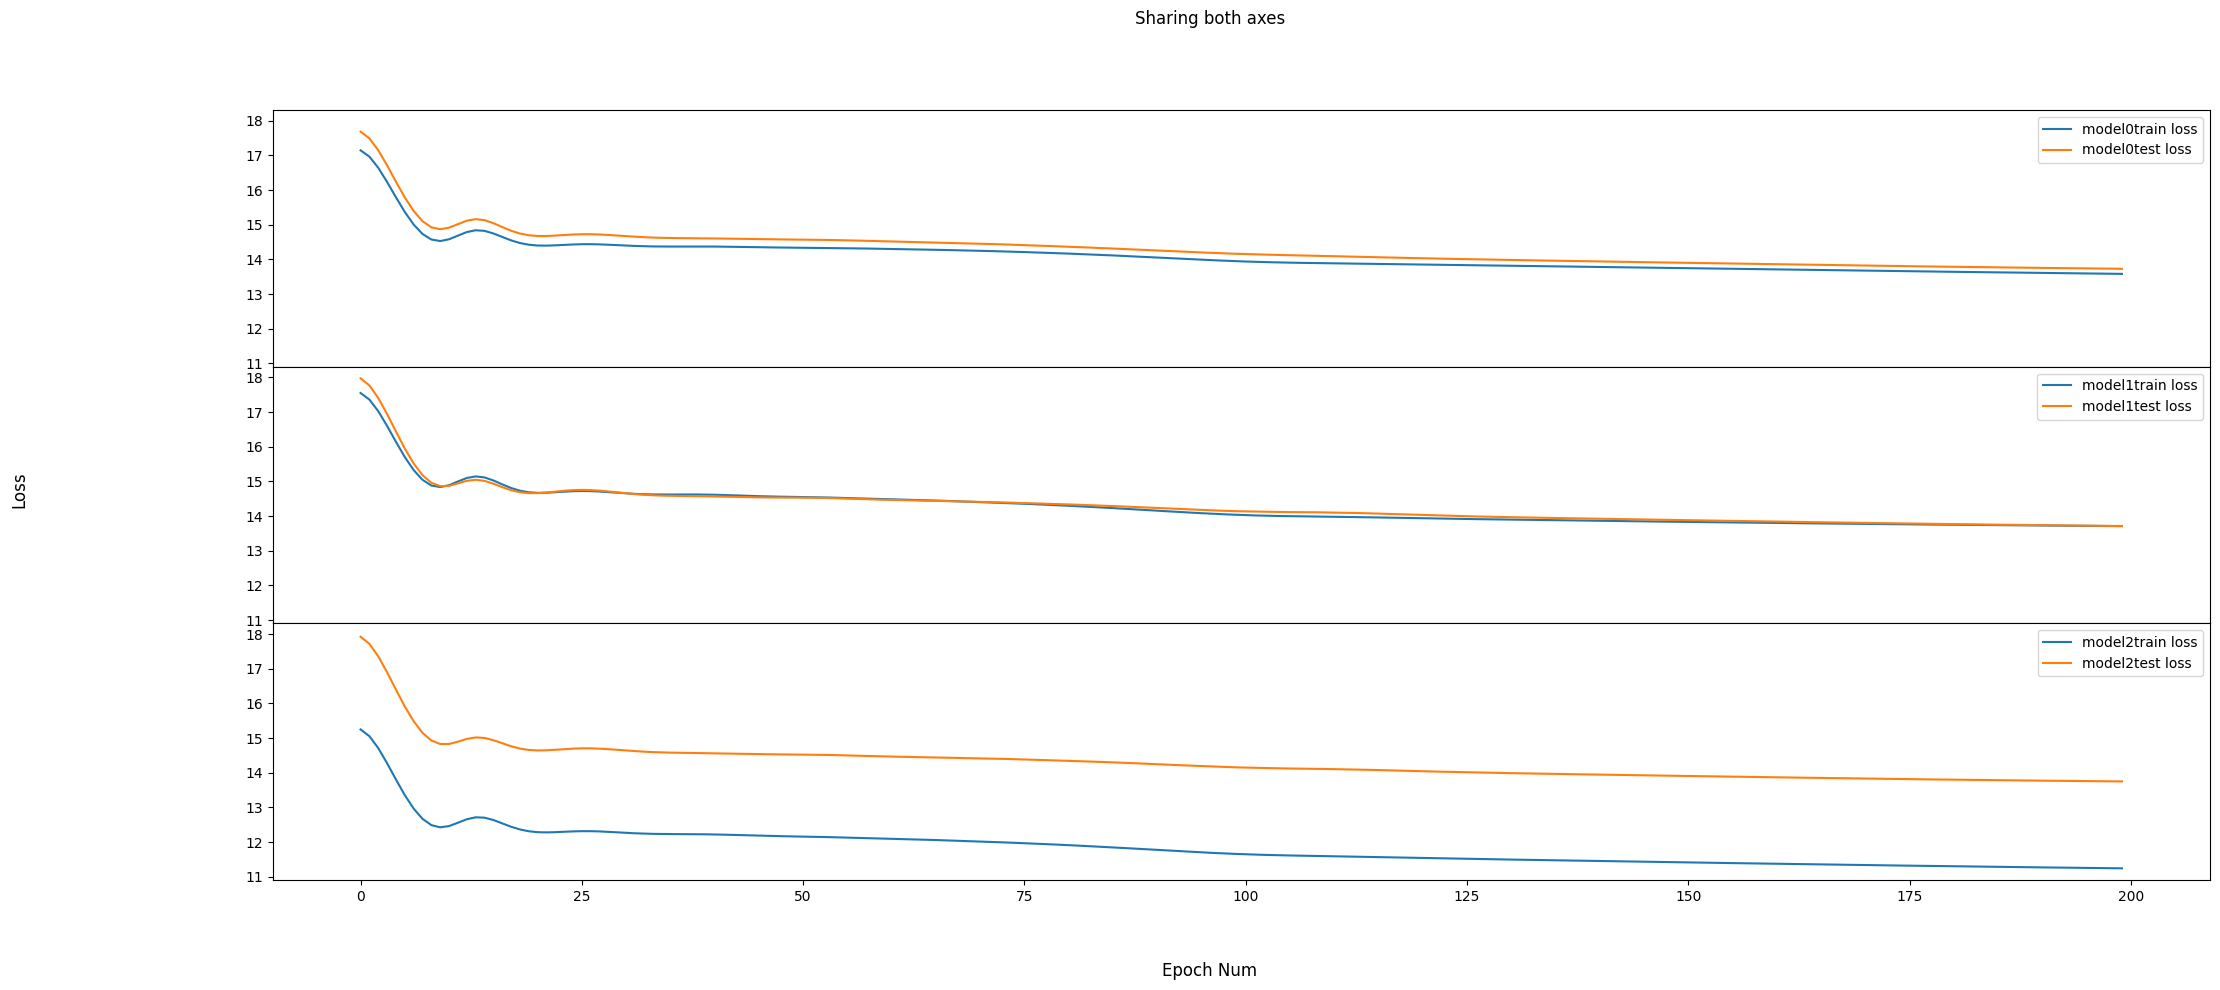

In [ ]:
################ Model Training Evaluation ################
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
fig.supxlabel("Epoch Num")
fig.supylabel("Loss")

for i in range(len(models)):
  model = models[i]
  axs[i].plot(model.trainLosses, label='model' + str(i) + 'train loss')
  axs[i].plot(model.testLosses, label='model' + str(i) + 'test loss')
  axs[i].legend()
  #axs[i].show()

# USE THIS FOR SEPARATE PLOTS
"""
for i in range(len(models)):
  model = models[i]
  plt.plot(model.trainLosses, label='model' + str(i) + 'train loss')
  plt.plot(model.testLosses, label='model' + str(i) + 'test loss')
  plt.xlabel('epoch no')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
"""
###########################################################

In [ ]:
### predictions
predBarrier = thr.Barrier(N+1)
allPreds = [None]*N

predMutex = thr.Lock()
def storePreds(i, preds):
  print("THREAD", i, "IS CURRENTLY WAITING FOR THE `allPreds` MUTEX TO BE ACQUIRED...")
  predMutex.acquire()
  try: allPreds[i] = preds
  finally:
    predMutex.release()
    print("THREAD", i, "HAS RELEASED THE `allPreds` MUTEX...")

def predWorker(num, XTest):
  # We wrap in a try-catch block in case one worker silently crashes. If there's no error,
  # we wont know it's dead, so there'll be a random deadlock at the barriers.
  try:
    model = models[num]
    preds = [None]*len(XTest)

    for i in range(len(YTest)):
      input_ = XTest[i].reshape(1, T, D)
      preds[i] = model(input_)[0,0].item()

    print("THREAD", num, "has completed its predictions.")
    storePreds(num, preds)
    print("THREAD", num, "is waiting for predBarrier.")
    predBarrier.wait() # wait for all threads to finish predictions
  except Exception as e:
    print("Thread", num, "died. Error:", e)
    sys.exit()

def predsCont(XTest, YTest):
  YTest = YTest.cpu().detach().numpy()
  M = len(XTest)
  threads = []
  for i in range(N):
    t = thr.Thread(target=predWorker, args=(i, XTest), daemon=True)
    t.start()
    print("Started thread", i, " using chunk", i, ".")
    threads.append(t)
  
  predBarrier.wait() # wait for all models to submit their predictions
  
  finalPreds = [None]*M

  # using average voting
  for predi in range(M):
    predsForThisInstance = []
    for modelsPreds in allPreds:
      predsForThisInstance.append(modelsPreds[predi])
    finalPreds[predi] = sum(predsForThisInstance)/len(predsForThisInstance)
    
  for t in threads:
    t.join()
  return finalPreds


In [ ]:
############################################################################ TESTING WITH TEST DATA SET ############################################################################

In [ ]:
YPreds = predsCont(XTest, YTest)

Started thread 0  using chunk 0 .
Started thread 1  using chunk 1 .
Started thread 2  using chunk 2 .
THREAD 0 has completed its predictions.
THREAD 0 IS CURRENTLY WAITING FOR THE `allPreds` MUTEX TO BE ACQUIRED...
THREAD 0 HAS RELEASED THE `allPreds` MUTEX...
THREAD 0 is waiting for predBarrier.
THREAD 2 has completed its predictions.
THREAD 2 IS CURRENTLY WAITING FOR THE `allPreds` MUTEX TO BE ACQUIRED...
THREAD 2 HAS RELEASED THE `allPreds` MUTEX...
THREAD 2 is waiting for predBarrier.
THREAD 1 has completed its predictions.
THREAD 1 IS CURRENTLY WAITING FOR THE `allPreds` MUTEX TO BE ACQUIRED...
THREAD 1 HAS RELEASED THE `allPreds` MUTEX...
THREAD 1 is waiting for predBarrier.


In [ ]:
plot_len = len(YPreds)
plot_df = dfDated[['date', 'precipitation']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = YPreds
plot_df.set_index('date', inplace=True)
plot_df.head(5)

,precipitation,prediction
date,,
2012-08-27,2.2,2.308011
2012-08-28,0.0,1.972791
2012-08-29,3.8,1.752083
2012-08-30,0.0,2.300520
2012-08-31,0.0,1.634930


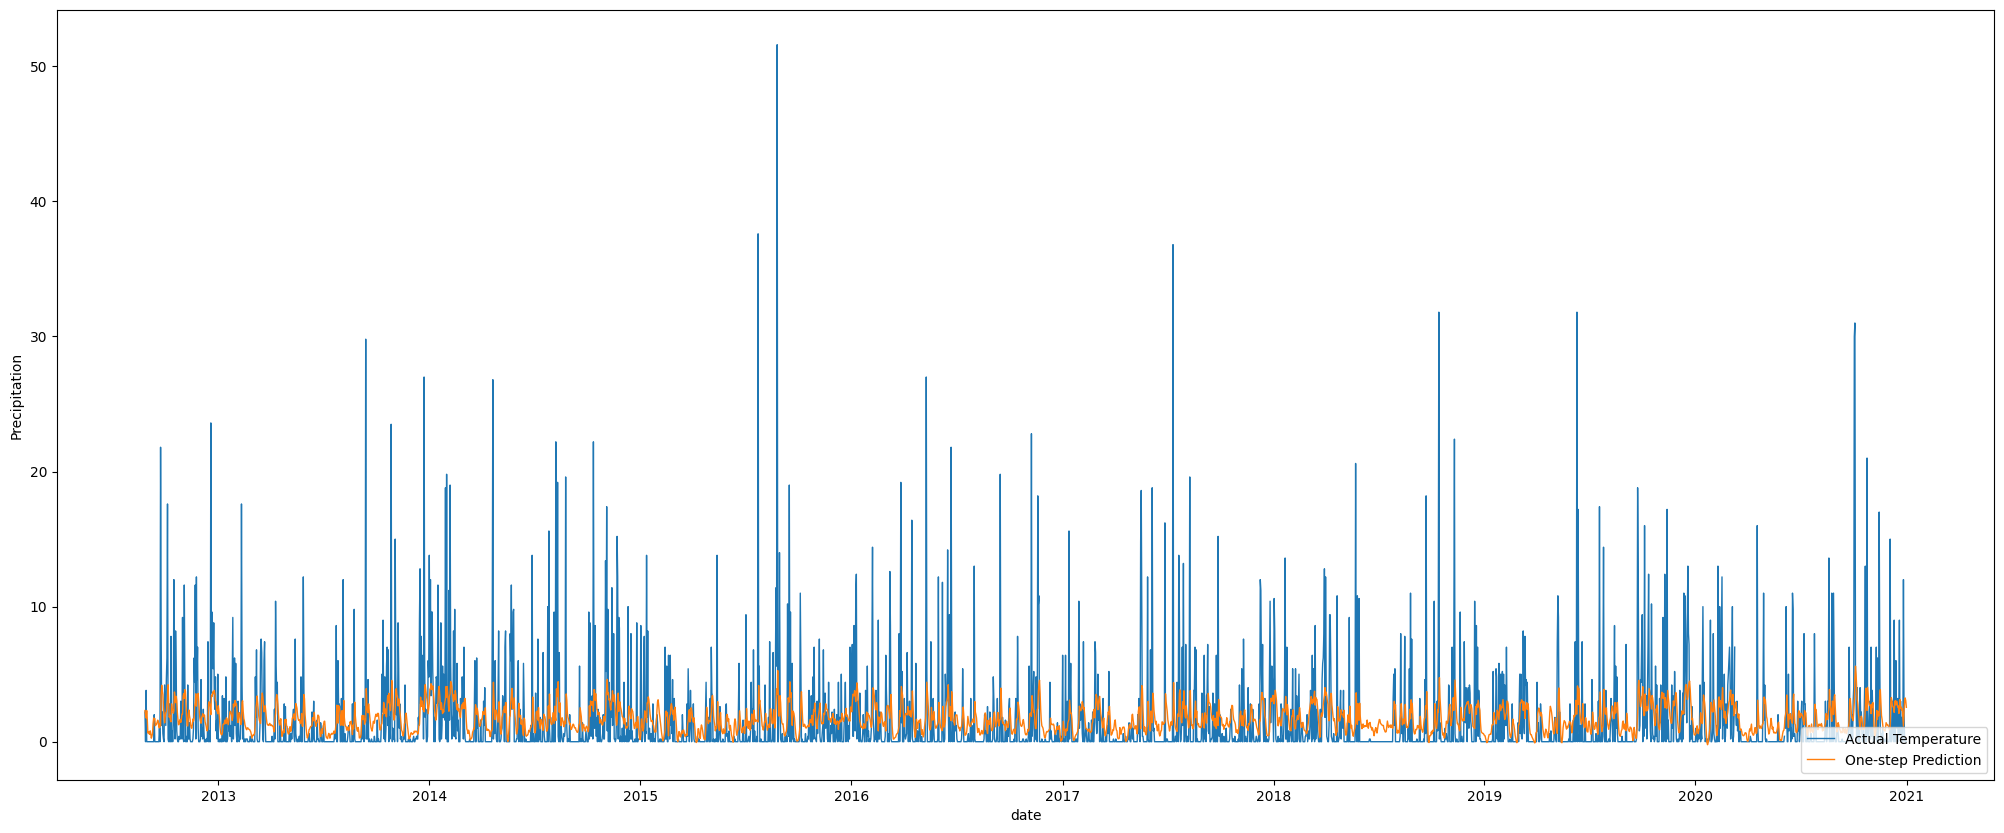

In [ ]:
plt.rcParams['figure.figsize'] = (25.0, 10.0)
plt.plot(plot_df['precipitation'], label='Actual Temperature', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('Precipitation')
plt.legend(loc='lower right')

In [ ]:
############################################################################ INFERENCING ############################################################################

In [ ]:
def compileSet(date, numDays:int = 20):
  dfOriginal = openSet(defaultPath = True)

  vars = preprocess(dfOriginal)
  #XTest, YTest = vars["datasets"][2], vars["datasets"][3]
  T, D, N = vars["dimensions"]["timesteps"], vars["dimensions"]["dimension"], vars["dimensions"]["N"]

  # find the requested instance index in the dataframe
  instance = dfOriginal.index[dfOriginal["date"] == date].to_numpy()[0]
  #print("org instance", instance)
  #print("last insance", instance+numDays+T)
  #print("num days", numDays)
  #print("T = ", T)
  lastInstance = int(instance + numDays + T)
  if lastInstance > dfOriginal.shape[0]: 
    raise Exception("""
                    Number of days forward has been chosen such that the data range exceeds the size of the dataset. 
                    Please change either `startDate` or `daysForward` such that the final date is less than 31/12/2020 
                    """)
  daysToInfer = dfOriginal.iloc[instance:lastInstance]
  print("sample size", daysToInfer.shape[0])
  #daysToInfer = pd.read_csv("asfdg.csv")
  vars = preprocess(daysToInfer, trainPercent = 0.0, timestep = 20) # we set to 0.0 because we want to just split the data into X and Y not training and testing.
  X, Y = vars["datasets"][2], vars["datasets"][3]
  
  # daysToInfer includes days of numDays + T (=N + 20) due to the sliding window. These are the first 20 days that we wanna remove. 
  dates = daysToInfer["date"].reset_index(drop = True).tolist()[T:]
  
  print("Num dates:", len(dates))
  return [dates, X, Y, T, D, N]

#london_weather.csv

def infer(startDate, daysForward = 7):
  #if daysForward < 21: raise Exception("daysForward parameter cannot be < 21.")
  #testTarget = YTest.cpu().detach().numpy()
  global T, D, N
  dates, X, Y, T, D, N = compileSet(startDate, daysForward)
  preds = []
  model = models[0]
  for i in range(len(Y)):
    input_ = X[i].reshape(1, T, D)
    input_ = input_.to(device)
    model.to(device)
    pred = model(input_)[0, 0].item()
    preds.append(pred)
  return [preds, Y, dates]

In [ ]:
preds, Y, dates = infer("1989-12-09", 100)
print(preds)
print(len(preds))
#london_weather.csv

15341 15341
trainingsize 3049
T 20
setSize 9
sample size 120
120 120
trainingsize 100
T 20
setSize 9
Num dates: 100
[0.9825109243392944, 0.8224921226501465, 0.7171025276184082, 0.6846938133239746, 0.7829027771949768, 0.8040419816970825, 0.8043036460876465, 0.7847577929496765, 0.7584201693534851, 1.1542500257492065, 0.9218291640281677, 0.6987596750259399, 0.4913341999053955, 0.39248859882354736, 0.43958330154418945, 0.6518659591674805, 0.700084924697876, 0.7380127310752869, 0.7817233204841614, 0.8029707670211792, 0.8873946070671082, 0.8529338836669922, 0.8313871622085571, 0.7170159816741943, 0.7213044166564941, 0.9131639003753662, 1.3031349182128906, 1.726396083831787, 2.2157747745513916, 2.218198537826538, 2.2467551231384277, 2.402035713195801, 2.4207804203033447, 2.708200454711914, 2.568665027618408, 2.56850528717041, 2.6270506381988525, 2.603947162628174, 1.7791492938995361, 1.3175499439239502, 1.8160138130187988, 2.1245927810668945, 1.8978228569030762, 1.299111008644104, 1.516118645

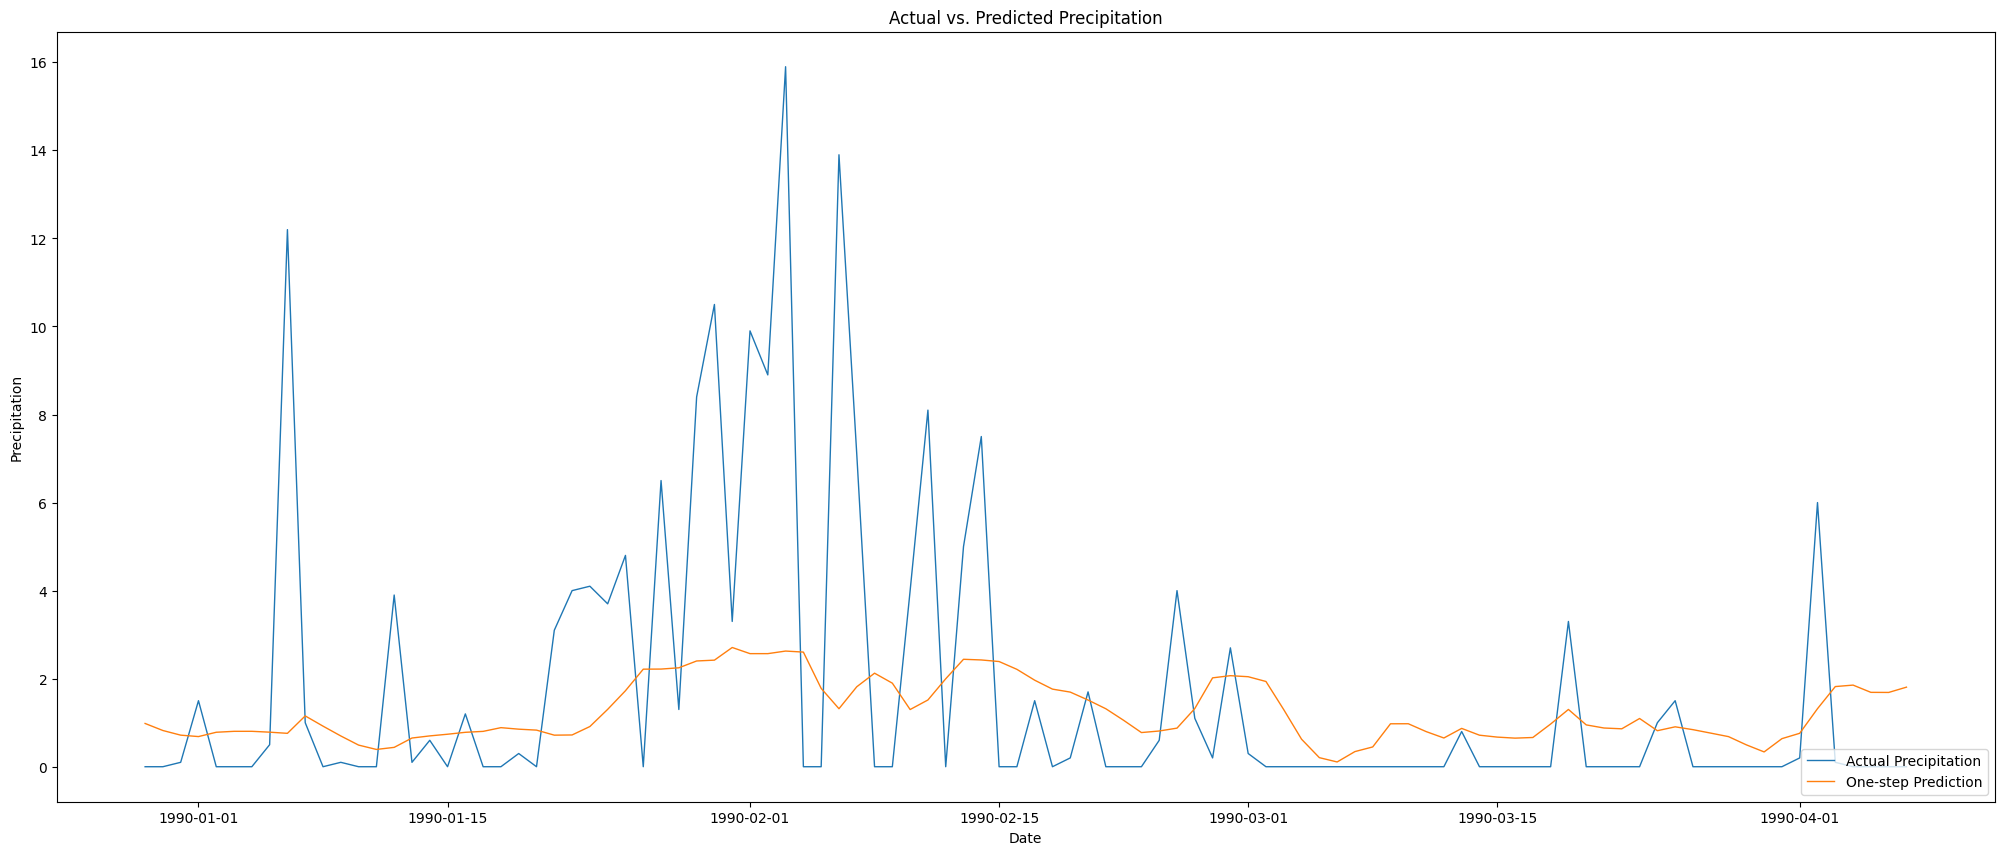

In [ ]:

# 1) Turn Y (tensor) into a 1‑D NumPy array
#    If Y is still a torch.Tensor, do Y = Y.cpu().detach().numpy().flatten()
#    If it’s already NumPy, just flatten it:
actual = Y.flatten()

# 2) Build a DataFrame with a DatetimeIndex
plot_df = pd.DataFrame({
    'precipitation': actual,
    'prediction':     preds
}, index=pd.to_datetime(dates))

# 3) Plot
plt.rcParams['figure.figsize'] = (25.0, 10.0)

plt.plot(plot_df['precipitation'], label='Actual Precipitation', linewidth=1)
plt.plot(plot_df['prediction'],    label='One‑step Prediction',   linewidth=1)

plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(loc='lower right')
plt.title('Actual vs. Predicted Precipitation')

plt.show()